<a href="https://colab.research.google.com/github/Marel88/Bioinfo_7_1/blob/master/Bio_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FOR GOOGLE DRIVE IMPORT**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**DATASET PRE PROCESSING**

In [0]:
!pip install py_wsi --no-index --find-links file:///Users/Mac/Desktop/py-wsi-1.1.zip
!apt install openslide-tool
!pip install openslide-python

#SCRIPT FOR IMAGE CROPPING


import py_wsi
import py_wsi.imagepy_toolkit as tk
from py_wsi import turtle

file_dir = "/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Healthy/"
db_location = "/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Healthy_patches/"
xml_dir = file_dir
patch_size = 64
level = 10
db_name = ""
overlap = 0

# All possible labels mapped to integer ids in order of increasing severity.
label_map = {}

turtle = turtle.Turtle(file_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map, storage_type='disk')
turtle.sample_and_store_patches(patch_size, level, overlap, load_xml=False, limit_bounds=True)


**SCRIPT FOR ERASING ONLY WHITE IMAGES**

In [0]:
#the function for deleting white patches

import cv2
import os
import glob

def deleteWhite(path):                                              #path is the path of the Patches folder
    """Function that deletes all patches that are completely (or mostly) white."""

    folders = [path + "/Healthy", path + "/Benign", path + "/Cancer"]
    for folder in folders:                                          #loops through the three folders of patches
        count = 0
        for filename in glob.glob(os.path.join(folder, '*.png')):   #sequentially selects each .png file in the current folder
            img = cv2.imread(filename)
            (x,y,z) = img.shape                                     #img.shap is 64 64 3
            white = 0
            for i in range(0,x):                                    #analyzes the image pixel by pixel
                for j in range(0,y):
                    pixel = img[i,j]
                    b = pixel[0]
                    g = pixel[1]
                    r = pixel[2]
                    if b == 255:                                    #if b,g,r are all 255 it means the pixel is white
                        if g == 255:
                            if r == 255:
                                white = white + 1                   #I use white as a counter to keep track of the number of white pixels
                    if white > 50:                                  #in the dataset that we have, an image having a few white pixels means it will be almost all white
                        break                                       #thus to make the process a bit shorter I only count to 50 white pixels and then break the loop, since it is unneded to count further
                if white > 50:
                    break
            if white > 50:                                          #if a patch is found to have many white pixels (which means it will be mostly white) I delete it from its folder
                os.remove(filename)
                count = count + 1
        print("Deleted",count,"patches in",folder)

    return;

In [0]:
#LOOP TO CLEAN UP FOLDERS

main_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset"
main_folders = [main_path + "/Test/Patches", main_path + "/Training/Patches", main_path + "/Validation/Patches"]
for main_folder in main_folders:
    new_path = main_folder
    deleteWhite(new_path)

**CNN BASE**

In [0]:
#CNN BASE MODEL - DATA LOADING

import numpy as np
!pip3 install keras
#!pip3 install tensorflow==1.5.0
!pip3 install tensorflow
!pip install mxnet-mkl
!pip3 install sklearn
!pip3 install keras_tqdm
!pip install scipy
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import *
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
train_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Training/Patches"
#train_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Patches/"
valid_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Validation/Patches"
#valid_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Validation/Patches"
#test_path ="/Users/Mac/Desktop/ROI-dataset-bioinf/Test/Patches"
test_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Test/Patches"

In [0]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=32)

Found 3306 images belonging to 3 classes.
Found 1589 images belonging to 3 classes.
Found 765 images belonging to 3 classes.


In [0]:
#For plotting images with labels
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [0]:
imgs, labels = next(train_batches)

#plots(imgs,titles=labels)


In [0]:
#CNN MODEL BUILDING
model = Sequential([Conv2D(32,(3,3),activation='relu',input_shape=(64,64,3)), Flatten(), Dense(3, activation='softmax'),])
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_batches, steps_per_epoch=22, validation_data=valid_batches, validation_steps=22, epochs=5, verbose=2)


In [0]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles = test_labels)
#test_labels = test_labels[:,0]
test_labels

In [0]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [0]:
predictions

In [0]:
!pip3 install -U scikit-learn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)

In [0]:
#MULTI-LABEL CONFUSION MATRIX

y_test_non_category = [ np.argmax(t) for t in test_labels ]
y_predict_non_category = [ np.argmax(t) for t in predictions ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

In [0]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):

#This function prints and plots the confusion matrix.
#Normalization can ben applied by setting 'normalize-True'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
           plt.text(j, i, "{:0.2f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
        else:
           plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [0]:
cm_plot_labels = ['Benign','Healthy','Cancer']
plot_confusion_matrix(conf_mat, cm_plot_labels,title ='Confusion Matrix')

**FIN QUI TUTTO OK, IL MODELLO FA SCHIFO MA TECNICAMENTE FA QUELLO CHE DEVE FARE, SE LA CONFUSION MATRIX È GIUSTA, HO TROVATO COME PLOTTARLA CON UN MODELLO A MULTI LABEL**

**FINE TUNING OF VGG16** 

In [0]:
#FINE TUNING OF A PRE-TRAINED MODEL (VGG16)

import numpy as np
!pip3 install keras
#!pip3 install tensorflow==1.5.0
!pip3 install tensorflow
!pip install mxnet-mkl
!pip3 install sklearn
!pip3 install keras_tqdm
!pip install scipy
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import *
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

vgg16_model = keras.applications.vgg16.VGG16()


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
vgg16_model.summary()


In [0]:
train_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Training/Patches"
#train_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Patches/"
valid_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Validation/Patches"
#valid_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Validation/Patches"
#test_path ="/Users/Mac/Desktop/ROI-dataset-bioinf/Test/Patches"
test_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Test/Patches"

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['Benign', 'Healthy', 'Cancer'], batch_size=32)

Found 3306 images belonging to 3 classes.
Found 1589 images belonging to 3 classes.
Found 765 images belonging to 3 classes.


In [0]:
type(vgg16_model)
#create a Sequential model in which we add all the layers of the VGG16 model
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  #all layers except for the last one which is the predictions layers we don't want
    model.add(layer)
    
#model.summary()

In [0]:
for layer in model.layers:
    layer.trainable = False


In [0]:
model.add(Dense(3, activation='softmax'))

#model.summary()

In [0]:
#TRAIN THE VGG16 MODEL
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
#lr=0.001
#steps per epoch and validation step = dataset size / batch size
model.compile(Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss ='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_batches, steps_per_epoch=33, validation_data=valid_batches, validation_steps=33, epochs=30, verbose=2, callbacks=[es])
model.save('/content/gdrive/My Drive/Bioinformatica/FirstVGG16.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 17s - loss: 0.9682 - acc: 0.5956 - val_loss: 0.7139 - val_acc: 0.7008
Epoch 2/30
 - 12s - loss: 0.5085 - acc: 0.7955 - val_loss: 0.5527 - val_acc: 0.8029
Epoch 3/30
 - 10s - loss: 0.3801 - acc: 0.8570 - val_loss: 0.4620 - val_acc: 0.8314
Epoch 4/30
 - 12s - loss: 0.3438 - acc: 0.8614 - val_loss: 0.4994 - val_acc: 0.8182
Epoch 5/30
 - 11s - loss: 0.2661 - acc: 0.9100 - val_loss: 0.4355 - val_acc: 0.8593
Epoch 6/30
 - 11s - loss: 0.2896 - acc: 0.8873 - val_loss: 0.4448 - val_acc: 0.8494
Epoch 7/30
 - 10s - loss: 0.2556 - acc: 0.9081 - val_loss: 0.4098 - val_acc: 0.8679
Epoch 8/30
 - 10s - loss: 0.2362 - acc: 0.9100 - val_loss: 0.3831 - val_acc: 0.8813
Epoch 9/30
 - 10s - loss: 0.2270 - acc: 0.9100 - val_loss: 0.4588 - val_acc: 0.8466
Epoch 10/30
 - 10s - loss: 0.2395 - acc: 0.9052 - val_loss: 0.3914 - val_acc: 0.8641


OSError: ignored

In [0]:
model.save('/content/gdrive/My Drive/Bioinformatica/FirstVGG16.h5')

In [0]:
test_imgs, test_labels = next(test_batches)
len(test_labels)
#plots(test_imgs, titles = test_labels)
#test_labels

32

In [0]:
#steps = images in the test folder / batch size
predictions = model.predict_generator(test_batches, steps= 1, verbose=0)
len(predictions)
#predictions = np.argmax(predictions, axis=-1) #multiple categories

32

In [0]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):

#This function prints and plots the confusion matrix.
#Normalization can ben applied by setting 'normalize-True'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
           plt.text(j, i, "{:0.2f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
        else:
           plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.3)
Confusion matrix, without normalization
[[ 2  6  2]
 [ 2 14  1]
 [ 1  3  1]]


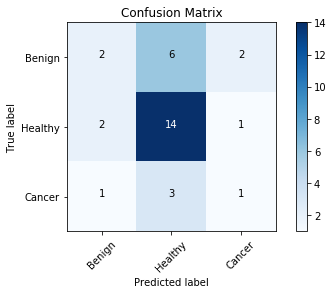

In [0]:
!pip3 install -U scikit-learn
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(test_labels, predictions)

#MULTI-LABEL CONFUSION MATRIX

y_test_non_category = [ np.argmax(t) for t in test_labels ]
#y_test_non_category = np.argmax(test_labels, axis=-1) #multiple categories
y_predict_non_category = [ np.argmax(t) for t in predictions ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

cm_plot_labels = ['Benign','Healthy','Cancer']
plot_confusion_matrix(conf_mat,cm_plot_labels,normalize=False,title ='Confusion Matrix')

**QUESTA DOVREBBE ESSERE LA FINE DELLA PRIMA PARTE DI TEST, SE FIN QUI I RISULTATI SONO BUONI, POSSIAMO FERMARCI SE NO BISOGNA FARE DATA AUGMENTATION E AUMENTARE LE EPOCHS**

In [0]:
#DATA AUGMENATION

#NOTE: every time this script is run, image crops will augment of a 6 factor

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True)

path="/content/gdrive/My Drive/Bioinformatica/Patches"

folders = [path + "/Healthy", path + "/Benign", path + "/Cancer"]
for folder in folders:                                          #loops through the three folders of patches
   for filename in glob.glob(os.path.join(folder, '*.png')):   #sequentially selects each .png file in the current folder
      print(filename)
      image = np.expand_dims(ndimage.imread(filename),0)
      aug_iter = gen.flow(image)
      aug_image = [next(aug_iter)[0].astype(np.uint8) for i in range(6)]  #get 6 samples of augmented images
      for i in range(len(aug_image)):                                     #save all the generated images
        scipy.misc.imsave(filename[:-4] + str(i) + '.png', aug_image[0])

**SE I RISULTATI OTTENUTI CON UN DETERMINATO SET DI IMPOSTAZIONI SONO BUONI E VOGLIAMO FREEZZARLI E RIPRODURLI ...**

In [0]:
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'

#Setting the seed for numpy-generated random numbers
np.random.seed(37)

#Setting the seed for Python random numbers
rn.seed(1254)

#Setting the seed for Tensorflow random numbers
tf.set_random_seed(89)

from keras import backend as K

#Force TensorFlow to use a single thread
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

#Paste training Keras code here after setting the random seeds

 **CLASS ACTIVION MAP**

In [0]:
# --- CLASS ACTIVATION MAP --- #
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from model import *
from data import *
import cv2

#After the last convolutional layer in a typical network like VGG16, we have an N-dimensional image, where N is the number of filters in this layer. 
#For example in VGG16, the last convolutional layer has 512 filters. For example, for an 1024x1024 input image (lets discard the fully connected layers, 
#so we can use any input image size we want), the output shape of the last convolutional layer will be 512x64x64. 
#Since 1024/64 = 16, we have a 16x16 spatial mapping resolution. 
#A global average pooling (GAP) layer just takes each of these 512 channels, and returns their spatial average. 
#Channels with high activations, will have high signals.

def global_average_pooling(x):
        return K.mean(x, axis = (2, 3))
  

def global_average_pooling_shape(input_shape):
        return input_shape[0:2]
  
#The second step is to assign a weight to each output from the global average pooling layer, for each of the categories. 
#This can be done by adding a dense linear layer + softmax, training an SVM on the GAP output, or applying any other linear classifier on top of the GAP. 
#These weights set the importance of each of the convolutional layer outputs.


#TO DO: 
#    --- definire una funzione che crei il modello VGG16 (ho visto che Elena ha creato il modello ma non dentro una funzione)
def get_model():
	    model = VGG16_convolutions()
	    model = load_model_weights(model, "vgg16_weights.h5")
	    
	    model.add(Lambda(global_average_pooling, 
	              output_shape=global_average_pooling_shape))
	    model.add(Dense(2, activation = 'softmax', init='uniform'))
	    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
	    model.compile(loss = 'categorical_crossentropy', \
            optimizer = sgd, metrics=['accuracy'])
	    return model

def load_model_weights(model, weights_path):
    print 'Loading model.'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
        model.layers[k].trainable = False
    f.close()
    print 'Model loaded.'
    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer    
       
#TO DO: 
# --- definire il "dataset_path"
# --- definire la funzione "load_images": è necessario creare due path diversi, uno per immagini positive e l'altro per quelle negative
#     (poi la faccio io appena riusciamo a fare i test)

def train(dataset_path):
        model = get_model()
        X, y = load_images(dataset_path)
	      print "Training.."
        checkpoint_path="weights.{epoch:02d}-{val_loss:.2f}.hdf5"
        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')
        model.fit(X, y, nb_epoch=40, batch_size=32, validation_split=0.2, verbose=1, callbacks=[checkpoint])

#Now to create a heatmap for a class we can just take output images from the last convolutional layer, multiply them by their assigned weights 
#(different weights for each class), and sum.

def visualize_class_activation_map(model_path, img_path, output_path):
        model = load_model(model_path)
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output, 
        model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 1
        for i, w in enumerate(class_weights[:, target_class]):
                cam += w * conv_outputs[i, :, :]
        print "predictions", predictions
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        img = heatmap*0.5 + original_img
        cv2.imwrite(output_path, img)

**ANOTHER FINE TUNING OF VGG16**

In [0]:
#NEW VGG16 TUNING

import numpy as np
!pip3 install keras
#!pip3 install tensorflow==1.5.0
!pip3 install tensorflow
!pip install mxnet-mkl
!pip3 install sklearn
!pip3 install keras_tqdm
!pip install scipy
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import *
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


from keras.applications import VGG16
#Load the VGG model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg16_model.layers:
    print(layer, layer.trainable)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
<keras.engine.input_layer.InputLayer object at 0x7fb99c4b7dd8> False
<keras.layers.convolutional.Conv2D object at 0x7fb997729dd8> False
<keras.layers.convolutional.Conv2D object at 0x7fb997729fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb99708b7f0> False
<keras.layers.convolutional.Conv2D object at 0x7fb99708b278> False
<keras.layers.convolutional.Conv2D object at 0x7fb997040588> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb997054c50> False
<keras.layers.convolutional.Conv2D object at 0x7fb9970547b8> False
<keras.layers.convolutional.Conv2D object at 0x7fb9970006a0> False
<keras.layers.convolutional.Conv2D object at 0x7fb997018eb8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb996fc3710> False
<keras.layers.convolutional.Conv2D object at 0x7fb996fc3240> False
<keras.layers.convolutional.Conv2D object at 0x7fb996f71390> False
<keras.layers.convolutional.Conv2D object at 0x7fb996f8

In [0]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
newVGG16_model = models.Sequential()
 
# Add the vgg convolutional base model
newVGG16_model.add(vgg16_model)
 
# Add new layers
newVGG16_model.add(layers.Flatten())
newVGG16_model.add(layers.Dense(1024, activation='relu'))
newVGG16_model.add(layers.Dropout(0.1))
newVGG16_model.add(layers.Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
newVGG16_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 32,773,635
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
train_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Training/Patches"
#train_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Training/Patches/"
valid_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Validation/Patches"
#valid_path="/Users/Mac/Desktop/ROI-dataset-bioinf/Validation/Patches"
#test_path ="/Users/Mac/Desktop/ROI-dataset-bioinf/Test/Patches"
test_path="/content/gdrive/My Drive/Bioinformatica/Organized dataset/Test/Patches"

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        valid_path,
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3306 images belonging to 3 classes.
Found 1589 images belonging to 3 classes.


In [0]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

# Compile the model
newVGG16_model.compile(loss='categorical_crossentropy',optimizer=
              Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['acc'])
# Train the model
history = newVGG16_model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)#, callbacks=[es])
 
# Save the model
newVGG16_model.save('/content/gdrive/My Drive/Bioinformatica/newVGG16.h5')

In [0]:
from keras.models import load_model
newVGG16 = load_model('/content/gdrive/My Drive/Bioinformatica/newVGG16.h5')

generator = ImageDataGenerator().flow_from_directory(
        '/content/gdrive/My Drive/Bioinformatica/Organized dataset/Test/Patches',
        target_size=(224, 224),
        batch_size=200)

probabilities = newVGG16_model.predict_generator(generator, 1)

In [0]:
probabilities = np.argmax(probabilities, axis=-1) #multiple categories

In [0]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):

#This function prints and plots the confusion matrix.
#Normalization can ben applied by setting 'normalize-True'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
           plt.text(j, i, "{:0.2f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
        else:
           plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.3)
Confusion matrix, without normalization
[[12  2 25]
 [ 7  4 17]
 [36  9 88]]


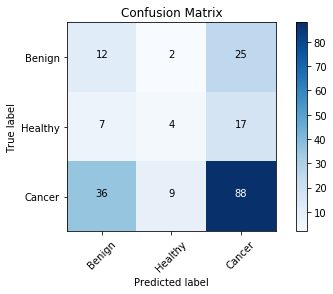

In [0]:
!pip3 install -U scikit-learn
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(test_labels, predictions)

#MULTI-LABEL CONFUSION MATRIX
test_dir, test_labels = next(generator)
test_img = [ np.argmax(t) for t in test_labels ]
#y_predict_non_category = [ np.argmax(t) for t in predictions ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_img, probabilities)

cm_plot_labels = ['Benign','Healthy','Cancer']
plot_confusion_matrix(conf_mat,cm_plot_labels,normalize=False,title ='Confusion Matrix')

**FINE TUNING RESNET50**

In [0]:
!pip install keras
!pip install h5py

!pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn
#http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/

!pip install -U coremltools

from keras.applications.resnet50 import ResNet50
from keras.models import Model,load_model
from keras.layers import Dense,GlobalAveragePooling2D,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta
import keras
import math, os, sys
import matplotlib.pyplot as plt
import coremltools



def get_model():
  
    input_tensor = Input(shape=(224, 224, 3))  # this assumes K.image_data_format() == 'channels_last'

    # create the base pre-trained model
    base_model = ResNet50(input_tensor=input_tensor,weights='imagenet',include_top=False)

    for layer in base_model.layers:
        layer.trainable=False

    x = base_model.output
    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    x = Dense(num_classes, activation='softmax')(x)

    updatedModel = Model(base_model.input, x)

    return  updatedModel



def compile_model(compiledModel):

    compiledModel.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])


def modelFitGenerator(fitModel):

    num_train_samples = sum([len(files) for r, d, files in os.walk(train_data_dir)])
    num_valid_samples = sum([len(files) for r, d, files in os.walk(validation_data_dir)])

    num_train_steps = math.floor(num_train_samples/batch_size)
    num_valid_steps = math.floor(num_valid_samples/batch_size)
    
    train_datagen = ImageDataGenerator(  
      rotation_range=90,      
      horizontal_flip=True,    
      vertical_flip=True,
      zoom_range=0.4)

    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=image_size ,
      batch_size=batch_size,
      class_mode='categorical', shuffle=True
    )

    validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=image_size ,
      batch_size=batch_size,
      class_mode='categorical', shuffle=True
    )

    print("start history model")
    history = fitModel.fit_generator(
      train_generator,
      steps_per_epoch=num_train_steps,
      epochs=nb_epoch,
      validation_data=validation_generator,
      validation_steps=num_valid_steps)
    
    printGraph(history)

def printGraph(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def saveCoreMLModel(kerasModel):
    coreml_model = coremltools.converters.keras.convert(kerasModel,
                                                    input_names=['input'],
                                                    output_names=['probs'],
                                                    image_input_names='input',
                                                    predicted_feature_name='predictedMoney',
                                                    class_labels = 'drive/Resnet/labels.txt')
    coreml_model.save('resnet50custom.mlmodel') 
    print('CoreML model saved')
    
    
def main():
    model = get_model()
    compile_model(model)
    modelFitGenerator(model)
    saveCoreMLModel(model)


if __name__ == '__main__':
    # constants
    image_size = (224, 224)
    train_data_dir = 'drive/Resnet/dataset/train' 
    validation_data_dir = 'drive/Resnet/dataset/test'
    nb_epoch = 50
    batch_size = 16
    num_classes = 6
    main()